In [3]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
from tqdm.notebook import tqdm

from laser_generic import Births_ConstantPop
from laser_generic import Infection
from laser_generic import Model
from laser_generic import Susceptibility
from laser_generic import Transmission
from laser_generic.importation import Infect_Random_Agents
from laser_generic.utils import seed_infections_randomly
from laser_generic.utils import set_initial_susceptibility_randomly

f"{np.__version__=}"

"np.__version__='2.1.3'"

OK, in testing here, we run into a couple of challenges, and my training in spectral
analysis is a bit old at this point.  Mainly, we're interested in relatively low-frequency
signals relative to our vector length - periods that can be order a few years in a sequence of a few decades,
so only a few oscillations.  Not impossible but tough
Second is that there are lots of other signals that will probably settle down over
time, but may not.  Lastly, there seem to be some windowing effects from the length of the
vector itself.
So some approaches to get arounds this:
Try to start relatively close to equilibrium
Use time-domain autocorrelation spectrum 
Instead of looking for the period of maximum power, specifically look for a peak in the vicinity of 
the expected period.


In [2]:
scenario = pd.DataFrame(data=[["homenode", 2e6]], columns=["name", "population"])
parameters = PropertySet(
    {"seed": 4, "nticks": 36500, "verbose": True, "beta": 0.4, "inf_mean": 12, "cbr": 45, "importation_period": 180, "importation_count": 3}
)

Simulating:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36500 [00:00<?, ?it/s]

  0%|          | 0/36500 [00:00<?, ?it/s]

  0%|          | 0/36500 [00:00<?, ?it/s]

  0%|          | 0/36500 [00:00<?, ?it/s]

  0%|          | 0/36500 [00:00<?, ?it/s]

  0%|          | 0/36500 [00:00<?, ?it/s]

  0%|          | 0/36500 [00:00<?, ?it/s]

  0%|          | 0/36500 [00:00<?, ?it/s]

  0%|          | 0/36500 [00:00<?, ?it/s]

  0%|          | 0/36500 [00:00<?, ?it/s]

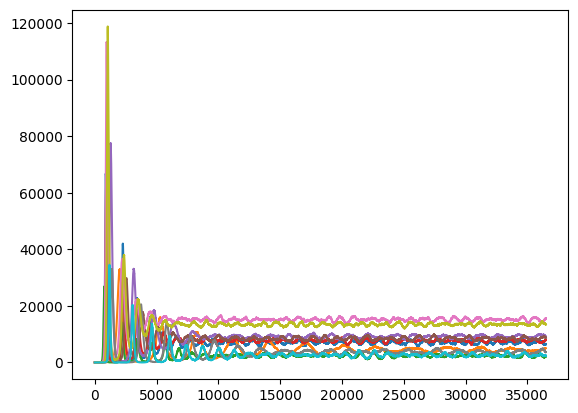

In [4]:
%%capture --no-display

from pathlib import Path

nsims = 10
nticks = 36500
cbrs = 15 + 85 * np.random.rand(nsims)
inf_means = 5 + 45 * np.random.rand(nsims)
R0s = 1.5 + 8.5 * np.random.rand(nsims)
mu = [((1 + cbr / 1000) ** (1 / 365) - 1) for cbr in cbrs]
A = [1 / ((R0 - 1) * mu) / 365 for R0, mu in zip(R0s, mu)]
G = [1 / (mu + 1 / inf_mean) / 365 for mu, inf_mean in zip(mu, inf_means)]
T_exp = [2 * math.pi * np.sqrt(A * G) for A, G in zip(A, G)]
mycases = np.zeros((nsims, nticks))
params_df = pd.DataFrame(
    {
        "cbr": cbrs,
        "inf_mean": inf_means,
        "R0": R0s,
        "A": A,
        "G": G,
        "T_exp": T_exp,
    }
)
i = 0
for cbr, inf_mean, R0 in tqdm(zip(cbrs, inf_means, R0s), desc="Simulating", total=nsims):
    mu = (1 + cbr / 1000) ** (1 / 365) - 1
    parameters = PropertySet(
        {
            "seed": 2,
            "nticks": 36500,
            "verbose": True,
            "beta": R0 * (mu + 1 / inf_mean),
            "inf_mean": inf_mean,
            "cbr": cbr,
            "importation_period": 180,
            "importation_count": 3,
        }
    )
    model = Model(scenario, parameters)
    model.components = [
        Births_ConstantPop,
        Susceptibility,
        Transmission,
        Infection,
        Infect_Random_Agents,
    ]

    set_initial_susceptibility_randomly(model, 1 / R0 + 0.02)
    seed_infections_randomly(model, ninfections=1)
    model.run()
    plt.plot(model.patches.cases)
    mycases[i] = np.squeeze(model.patches.cases)
    i = i + 1

output_folder = (Path.cwd().parent.parent / "laser-generic-outputs" / "periodicity").absolute()
Path.mkdir(output_folder, parents=True, exist_ok=True)
params_df.to_csv(output_folder / "params_df.csv", index=False)
np.save(output_folder / "mycases.npy", mycases)

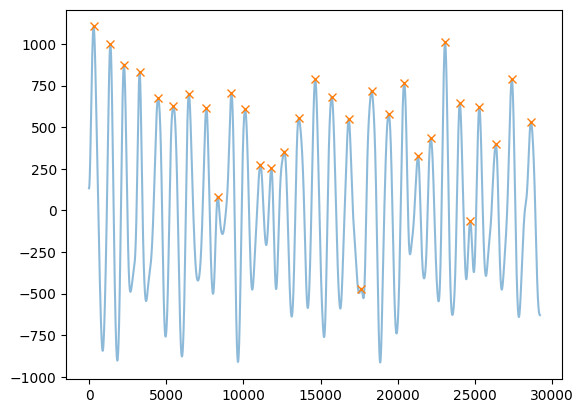

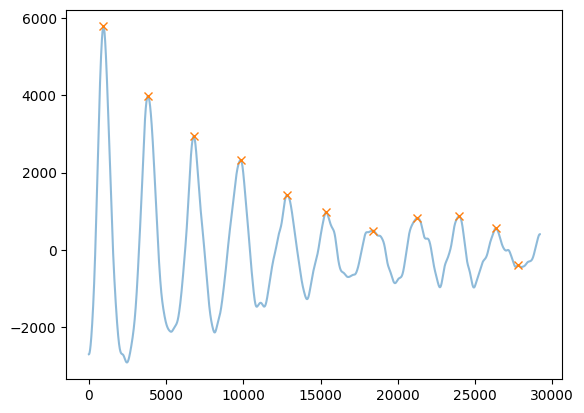

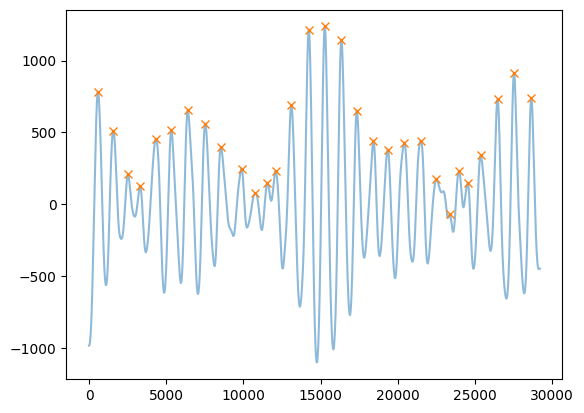

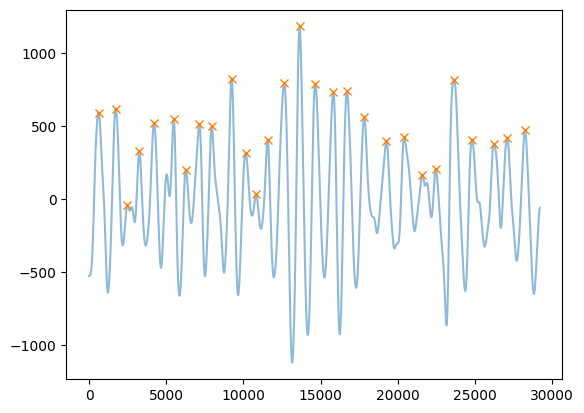

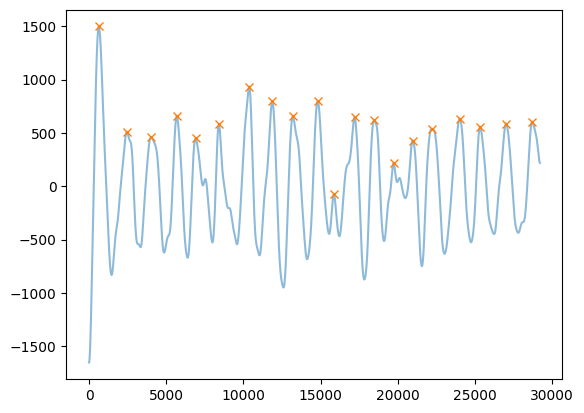

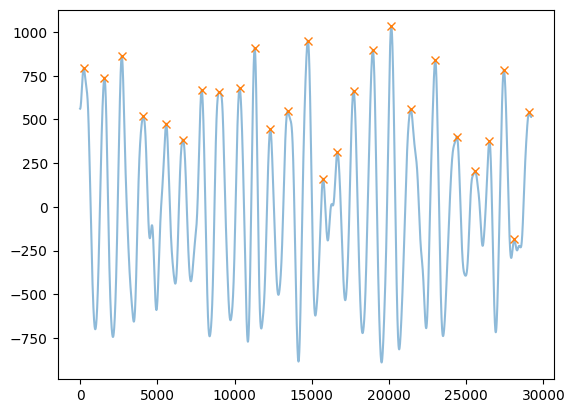

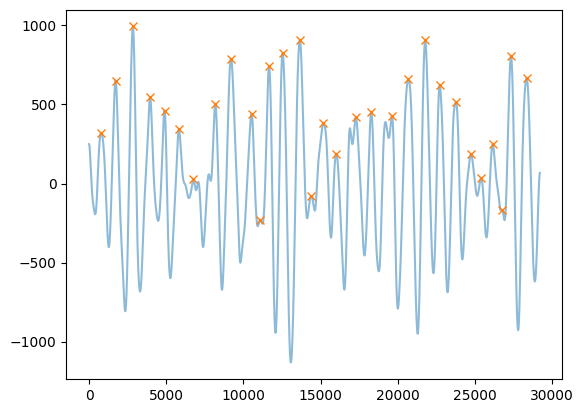

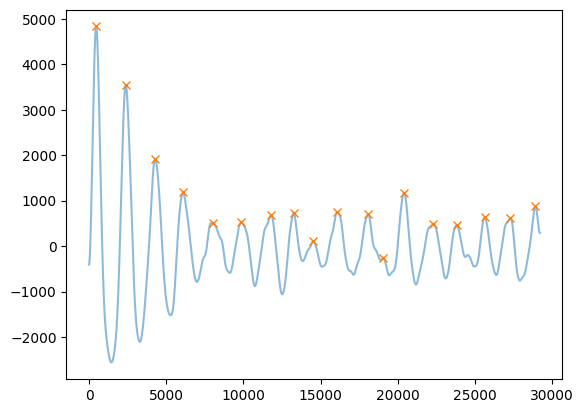

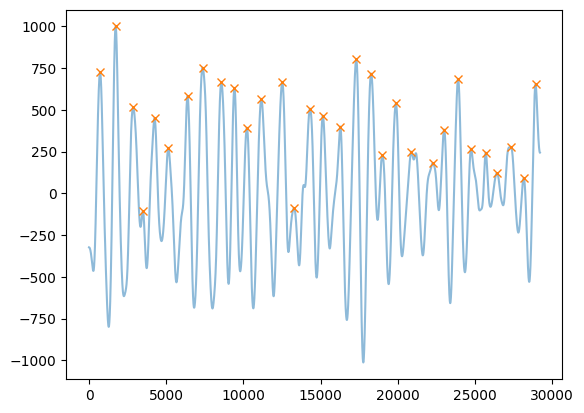

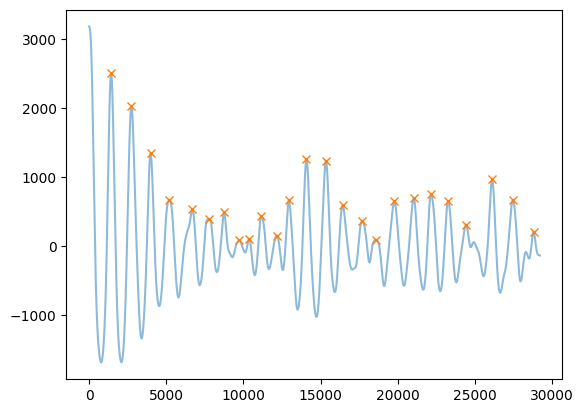

In [5]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

params_df["T_obs_peakfinder"] = np.nan
params_df["T_obs_autocorr"] = np.nan

for i in range(10):
    y0 = np.squeeze(mycases[i, :])
    y = y0[7300:]
    y = y - np.mean(y)
    y = gaussian_filter1d(y, sigma=100)
    peaks, _ = find_peaks(y, distance=params_df.loc[i, "T_exp"] * 365 / 2)
    plt.figure()
    plt.plot(y, alpha=0.5)
    plt.plot(peaks, y[peaks], "x")
    params_df.loc[i, "T_obs_peakfinder"] = np.median(np.diff(peaks)) / 365

    # Compute the FFT of the zero-padded signal
    Y1 = np.fft.fft(y0[7300:] - np.mean(y0[7300:]))

    # Compute the circular autocorrelation using the inverse FFT
    circular_autocorr = np.fft.ifft(Y1 * np.conj(Y1)).real
    # Plot only the positive frequency spectrum
    peaks, _ = find_peaks(circular_autocorr, distance=300)
    params_df.loc[i, "T_obs_autocorr"] = peaks[0] / 365

In [6]:
params_df["mu"] = (1 + params_df["cbr"] / 1000) ** (1 / 365) - 1

params_df["A"] = 1 / ((params_df["R0"] - 1) * params_df["mu"]) / 365
params_df["T_exp"] = 2 * np.pi * np.sqrt(params_df["A"] * params_df["G"])

In [7]:
params_df

,cbr,inf_mean,R0,A,G,T_exp,T_obs_peakfinder,T_obs_autocorr,mu
0,84.792945,20.655504,4.804935,3.228776,0.056331,2.679615,2.663014,2.783562,0.000223
1,37.133242,35.488490,2.844898,14.865667,0.096885,7.540514,7.890411,7.969863,0.000100
2,28.346454,18.097127,9.854431,4.040246,0.049513,2.810227,2.780822,2.926027,0.000077
3,71.351236,25.485511,5.808323,3.017281,0.069489,2.877037,2.783562,2.909589,0.000189
4,45.765762,44.490962,7.072667,3.679651,0.121232,4.196540,4.087671,4.216438,0.000123
5,49.064056,37.332896,8.458088,2.799130,0.101783,3.353741,3.115068,3.252055,0.000131
6,71.828798,46.105778,8.718547,1.867559,0.125220,3.038461,2.580822,2.860274,0.000190
7,39.603413,24.157984,3.919006,8.820037,0.066017,4.794480,4.945205,5.238356,0.000106
8,74.340820,40.313406,7.569432,2.122591,0.109580,3.030248,2.458904,2.704110,0.000196
9,51.256139,13.697542,3.821292,7.090482,0.037457,3.238066,3.143836,3.430137,0.000137


In [8]:
mycases[i] = np.squeeze(model.patches.cases)